In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.display.max_columns = None

In [2]:
df_fifa22 = pd.read_csv("../data/players_22.csv")
df_goles22 = pd.read_csv("../data/All_stats_2022_id.csv")

# Limpiar datos

In [3]:
df_fifa22 = df_fifa22.rename(columns={"sofifa_id":"id_fiffa"})

In [4]:
df_goles22.replace('-',0, inplace=True)
df_goles22["Goals_x"]=df_goles22["Goals_x"].astype(int);

# Seleccionar cols

In [5]:
df_goles22 = df_goles22[["id_fifa","nom_jugad","Rating_x","Goals_x"]]
# df_goles22 = df_goles22[["id_fifa",'Player_x', 'Apps_x', 'Mins_x', 'Assists', 'SpG', 'KeyP',
#        'Drb', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Rating_x', 'Liga_x',
#        'num_x', 'nom_jugad', 'equipo_x', 'ns_x', 'posicion_x','Goals_x']]

In [6]:
# df_fifa22 = df_fifa22[["id_fifa","short_name", "overall","value_eur","shooting","skill_ball_control","skill_fk_accuracy","skill_fk_accuracy","mentality_penalties"]]
# df_fifa22 = df_fifa22[["id_fifa","overall","short_name","value_eur","shooting","skill_ball_control","mentality_penalties"]]
df_fifa22 = df_fifa22[["id_fifa","short_name","overall","shooting","value_eur"]]

In [7]:
df = pd.merge(df_fifa22, df_goles22, on="id_fifa", how="outer")

In [8]:
df = df.dropna(subset=["short_name"])
df = df.dropna(subset=["shooting"])
df = df.dropna(subset=["nom_jugad"])

In [9]:
# Ordenar por short_name y luego por overall (de mayor a menor)
df = df.sort_values(by=['short_name', 'overall'], ascending=[True, False])

# Eliminar duplicados, manteniendo el primero (el de mayor overall)
df = df.drop_duplicates(subset='short_name', keep='first')


In [10]:
df.drop(columns=["nom_jugad","short_name","id_fifa"], inplace=True)

In [11]:
df["value_eur"] = df["value_eur"].astype(int)
df["Goals_x"] = df["Goals_x"].astype(int)
df["shooting"] = df["shooting"].astype(int)
df["overall"] = df["overall"].astype(int)

In [12]:
df.head()

,overall,shooting,value_eur,Rating_x,Goals_x
15731,70,59,1700000,6.94,1
16599,71,72,4600000,6.50,0
6720,76,77,12000000,6.15,1
17899,63,45,1000000,5.92,0
3809,66,38,700000,6.33,0


<Axes: >

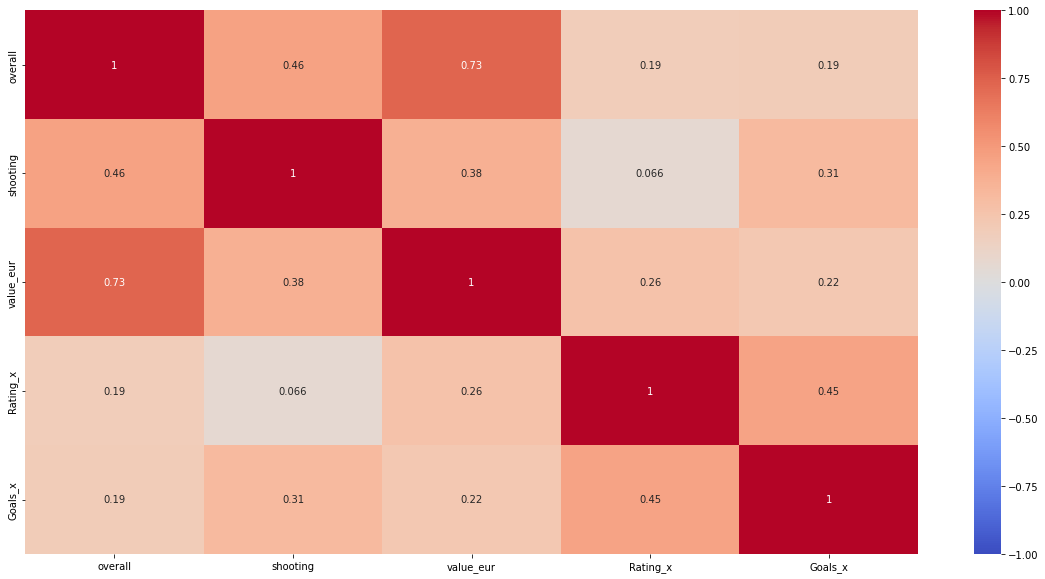

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm",vmin=-1,vmax=1)

In [14]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# Seleccionar características y variable objetivo
X = df.select_dtypes(include="number").drop(["Goals_x"], axis=1)
Y = df['Goals_x']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', LinearRegression())
])

linear_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [LinearRegression()]
}

search_space = [
    linear_params
]

gs = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 10,
                  scoring='r2',
                  verbose=2,
                  n_jobs=-1)

gs.fit(X_train, Y_train)

# Guardar el mejor modelo en un archivo .pkl
best_model = gs.best_estimator_
with open('../models/ModeloSimpleFifa_best_linear_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Evaluación del modelo
Y_pred = best_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Resultados
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Mean Squared Error: 2.129110313279086
Mean Absolute Error: 0.9997493555906383
R-squared: 0.2467770118116438


In [15]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),  # o MinMaxScaler
    ('classifier', xgb.XGBRegressor())  # Cambiar el clasificador por el regressor
])

# Definir el espacio de parámetros para GridSearchCV
xgb_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [xgb.XGBRegressor()],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# Configurar GridSearchCV
gs = GridSearchCV(estimator=pipe,
                  param_grid=xgb_params,
                  cv=10,
                  scoring='r2',
                  verbose=2,
                  n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
gs.fit(X_train, Y_train)

# Guardar el mejor modelo encontrado
best_model_xgb = gs.best_estimator_
with open('../models/ModeloSimpleFifa_best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)

# Evaluación del modelo

Y_pred_xgb = best_model_xgb.predict(X_test)
mse_xgb = mean_squared_error(Y_test, Y_pred_xgb)
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
r2_xgb = r2_score(Y_test, Y_pred_xgb)

# Mostrar los resultados
print(f"Mean Squared Error (XGBoost): {mse_xgb}")
print(f"Mean Absolute Error (XGBoost): {mae_xgb}")
print(f"R-squared (XGBoost): {r2_xgb}")


Fitting 10 folds for each of 54 candidates, totalling 540 fits
Mean Squared Error (XGBoost): 2.4823523335433735
Mean Absolute Error (XGBoost): 0.9587539107159332
R-squared (XGBoost): 0.12180936336517334
